/TL/epigenetics2/work/pebert/conda/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/TL/epigenetics2/work/pebert/conda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


run_hcop executed
run_orthodb executed
run_hcop executed
run_orthodb executed
run_hcop executed
run_orthodb executed


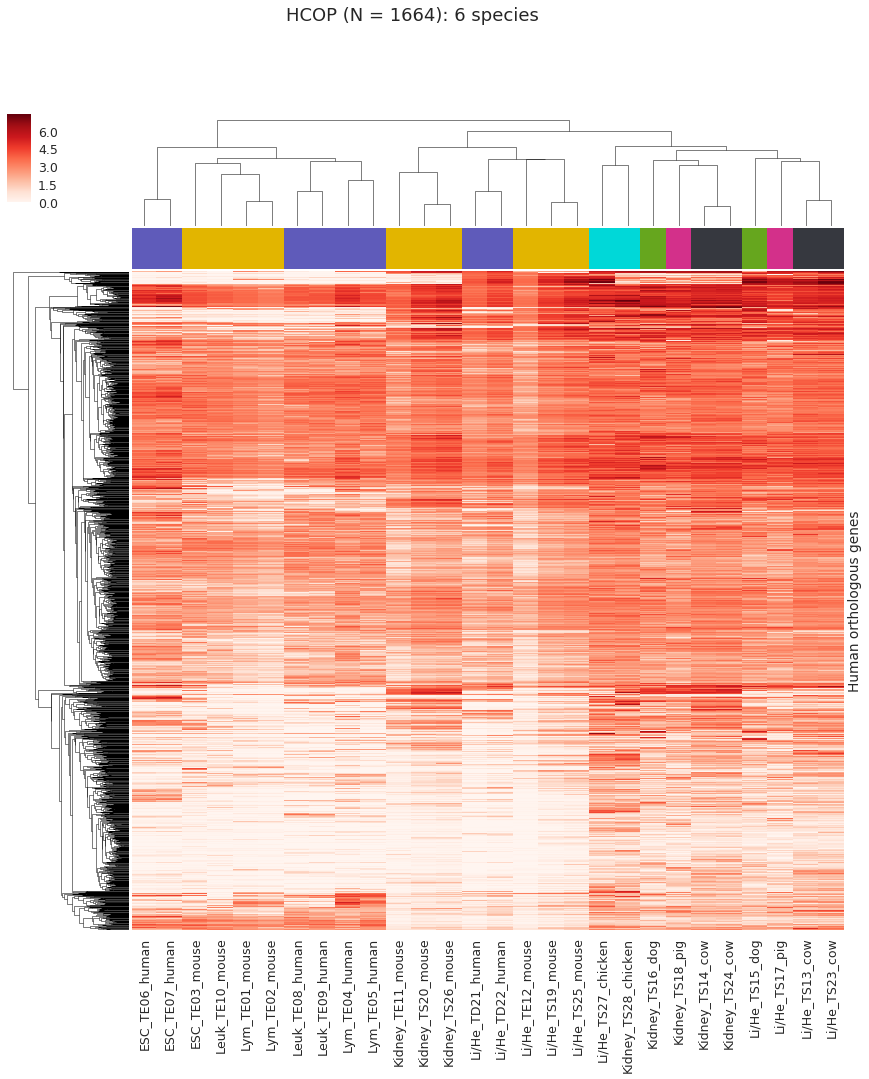

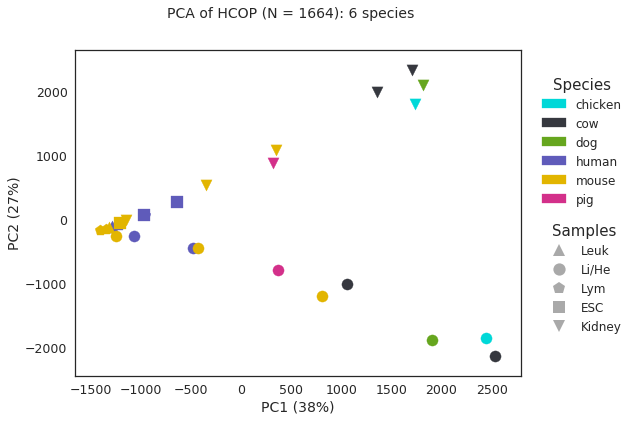

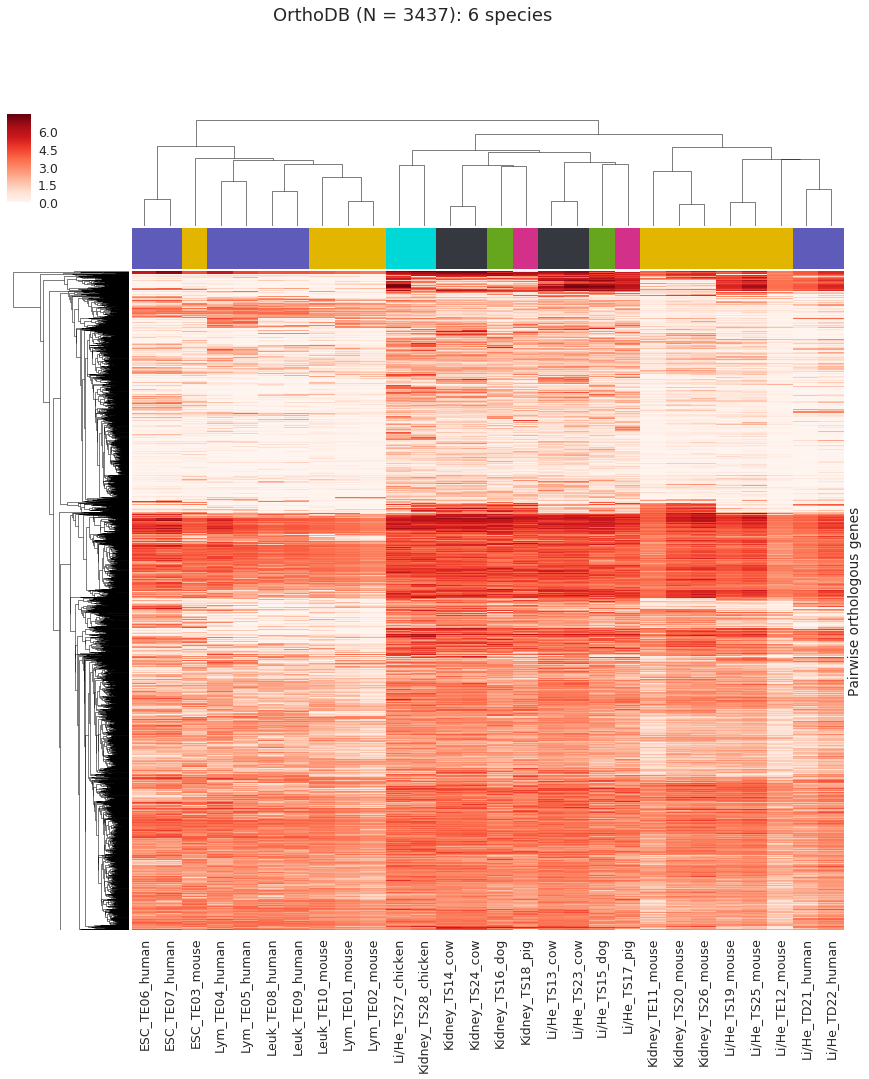

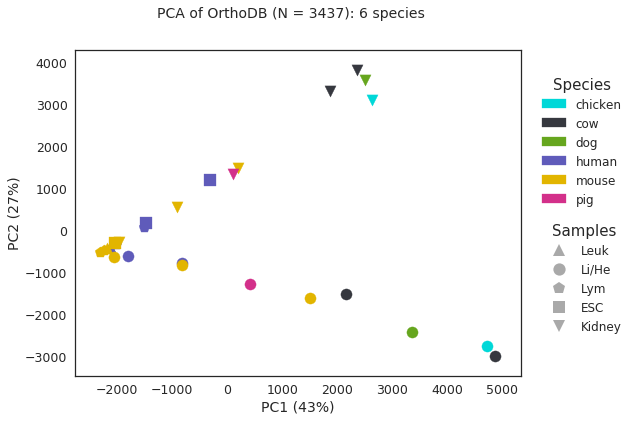

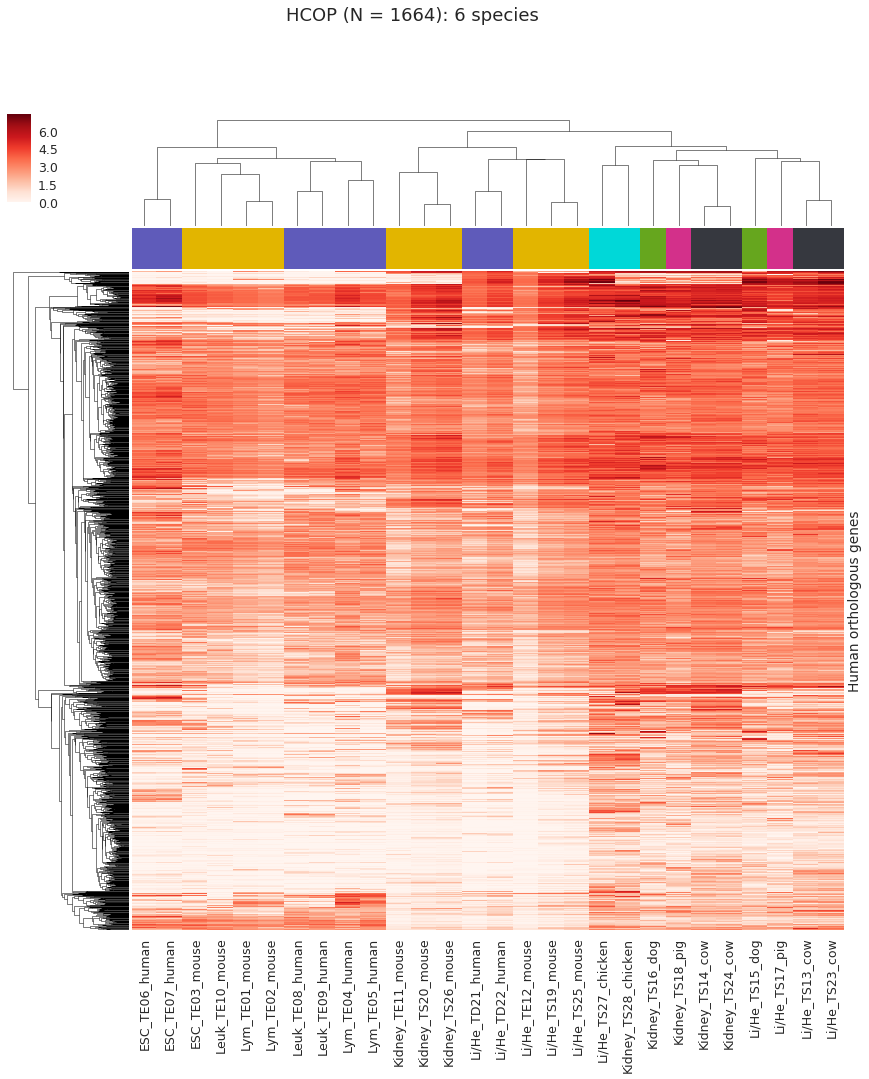

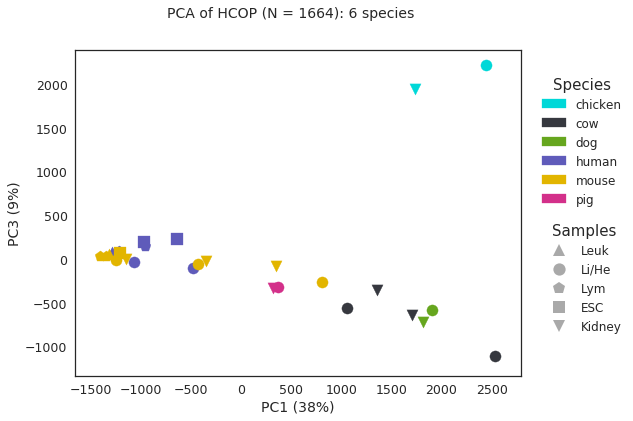

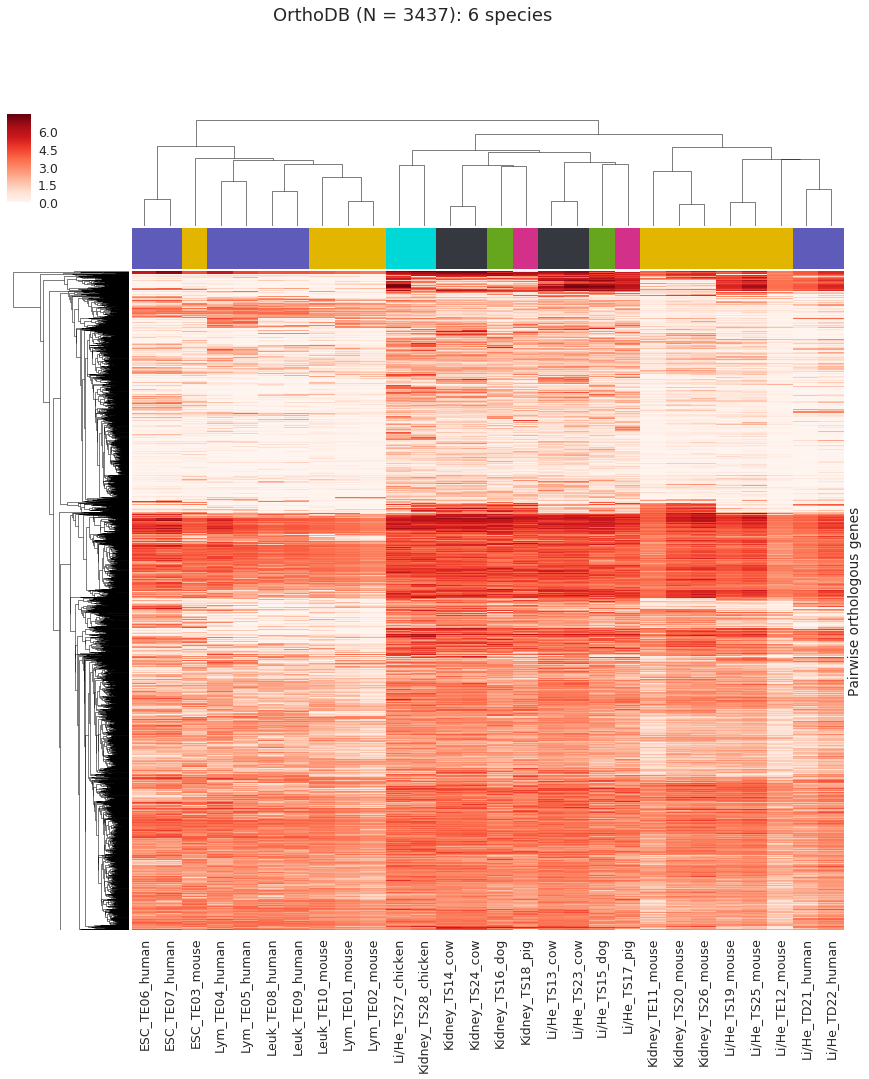

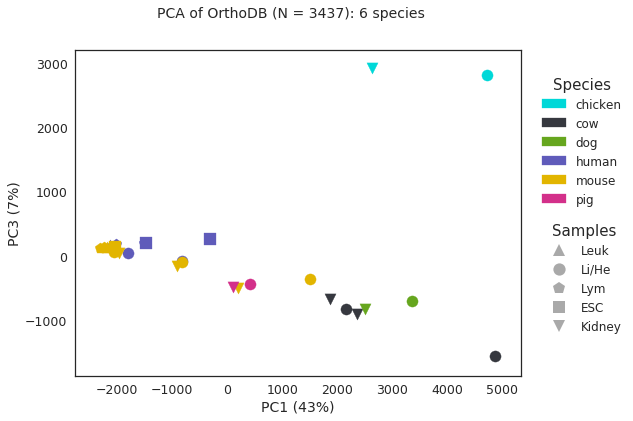

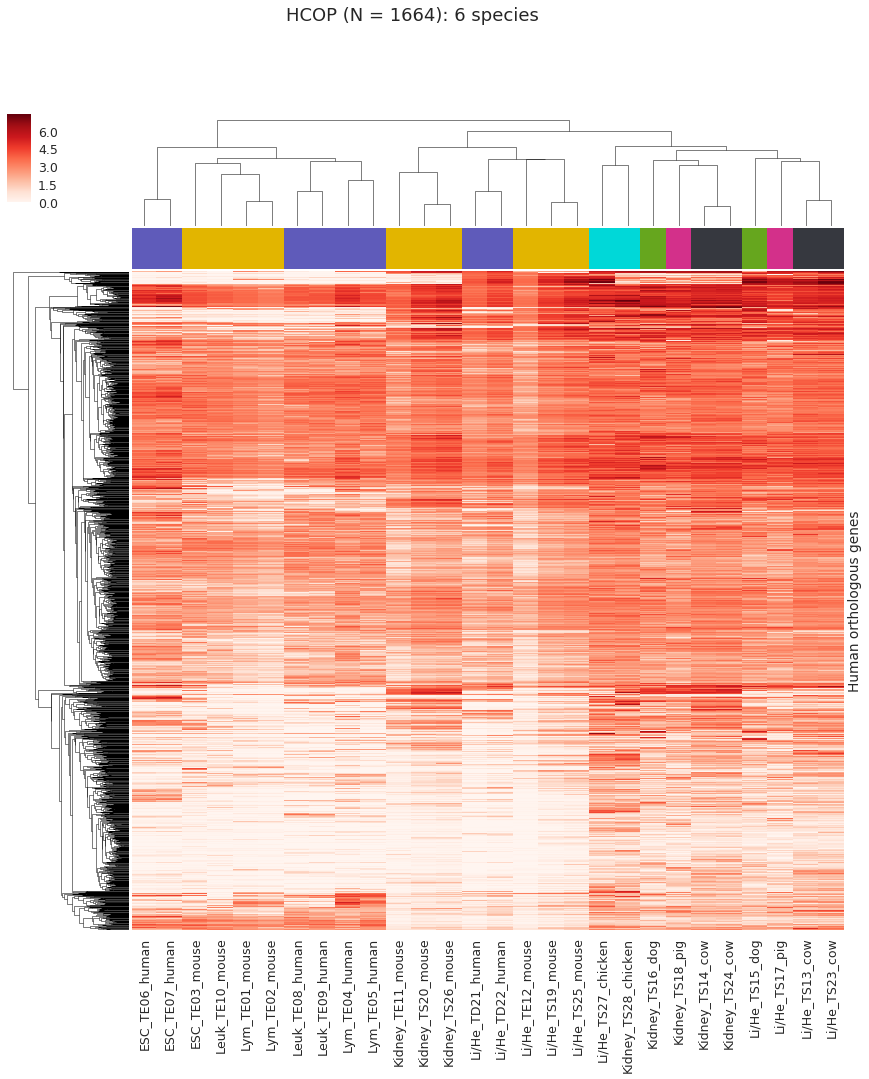

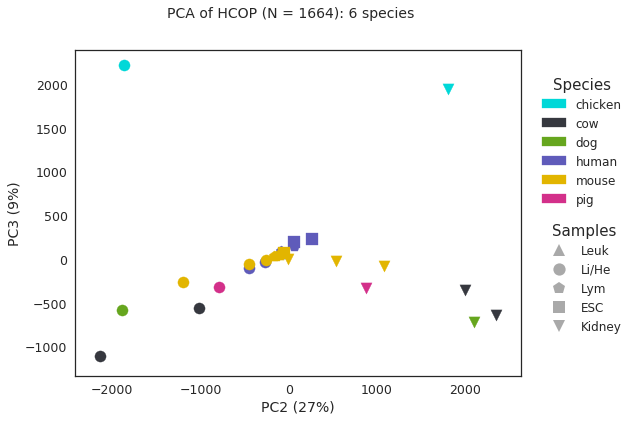

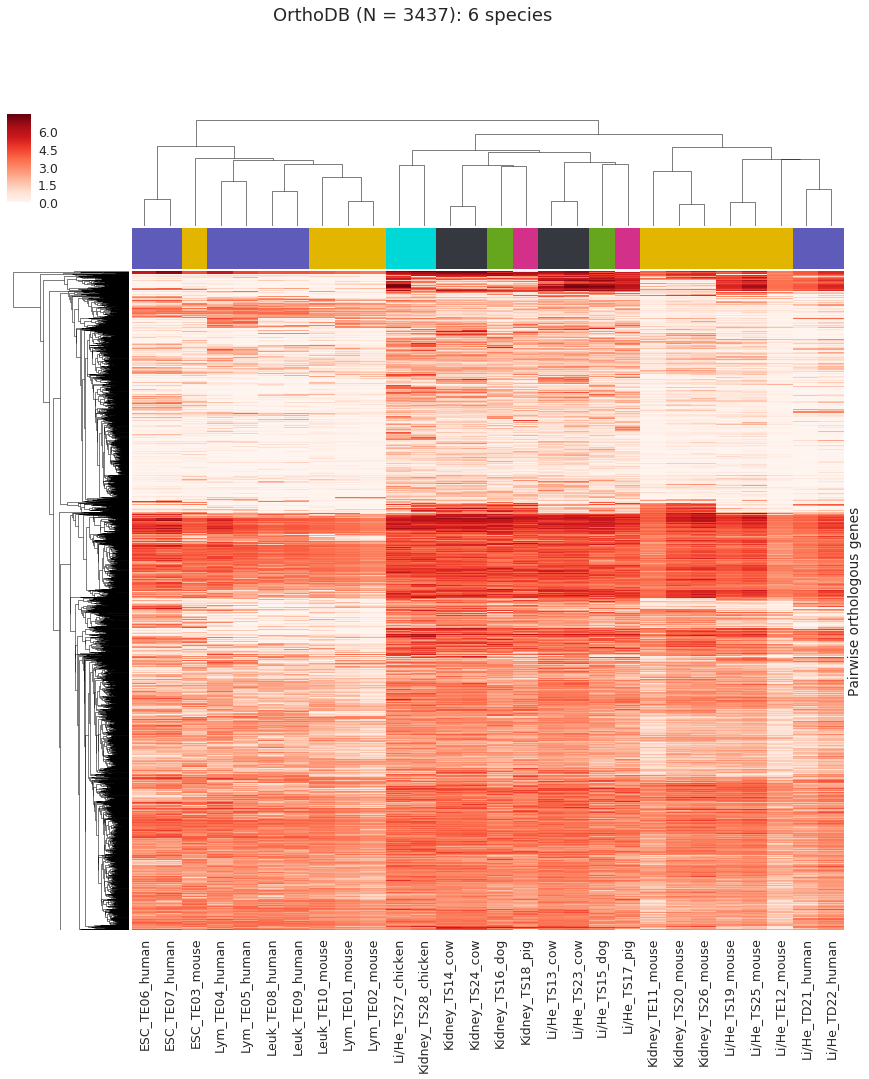

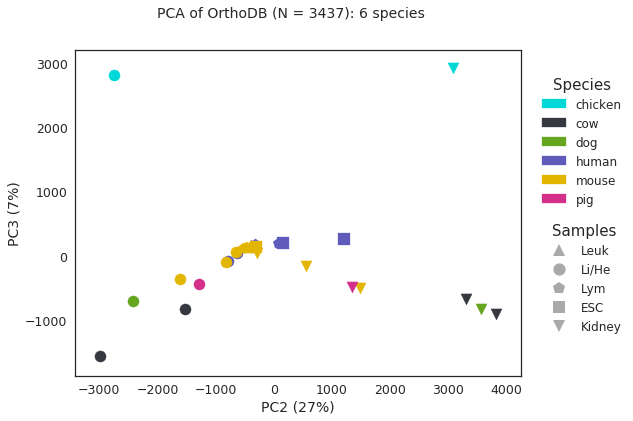

In [1]:
%matplotlib inline

import os as os
import numpy as np
import json as js
import pandas as pd
import sklearn.decomposition as decomp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['Arial', 'sans-serif']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
data_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

pca_comp_x = None
pca_comp_y = None

exec_hcop = True
exec_orthodb = True

show_figures = False

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def run_hcop(pc1, pc2):
    if not exec_hcop:
        return False
    hcop_data = os.path.join(data_folder, 'orthopred_hcop_6species.h5')
    with pd.HDFStore(hcop_data, 'r') as hdf:
        expdata = hdf['/matrix/auto/data']
        num_species = len([c for c in expdata.columns if c.endswith('_name')])
        drop_cols = [c for c in expdata.columns if c.endswith('_name') or c.endswith('_symbol')]
        expdata.drop(drop_cols, axis=1, inplace=True)
    expdata.index.name = 'Human orthologous genes'
    smp_ann = annotate_samples(expdata.columns)
    plt_title = 'HCOP (N = {}): {} species'.format(expdata.shape[0], num_species)
    heatm = plot_heatmap(expdata.copy(), plt_title, smp_ann)
    if save_figures:
        outpath = os.path.join(out_folder, 'supp', 'fig_X_supp_hcop-cluster_{}spec.svg'.format(num_species))
        heatm.savefig(outpath)
    scat, exart = plot_pca_scatter(expdata.copy(), plt_title, smp_ann, pc1, pc2)
    if save_figures:
        outpath = os.path.join(out_folder, 'main',
                               'fig_X_main_hcop-pca_{}spec_{}vs{}.svg'.format(num_species, pc1 + 1, pc2 + 1))
        scat.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    return True


def run_orthodb(pc1, pc2):
    if not exec_orthodb:
        return False
    odb_data = os.path.join(data_folder, 'orthopred_odb_6species.h5')
    with pd.HDFStore(odb_data, 'r') as hdf:
        expdata = hdf['/matrix/auto/data']
        num_species = len([c for c in expdata.columns if c.endswith('_name')])
        drop_cols = [c for c in expdata.columns if c.endswith('_name') or c.endswith('_symbol')]
        expdata.drop(drop_cols, axis=1, inplace=True)
    expdata.index.name = 'Pairwise orthologous genes'
    smp_ann = annotate_samples(expdata.columns)
    plt_title = 'OrthoDB (N = {}): {} species'.format(expdata.shape[0], num_species)
    heatm = plot_heatmap(expdata.copy(), plt_title, smp_ann)
    if save_figures:
        outpath = os.path.join(out_folder, 'supp', 'fig_X_supp_orthodb-cluster_{}spec.svg'.format(num_species))
        heatm.savefig(outpath)
    scat, exart = plot_pca_scatter(expdata.copy(), plt_title, smp_ann, pc1, pc2)
    if save_figures:
        outpath = os.path.join(out_folder, 'main',
                               'fig_X_main_orthodb-pca_{}spec_{}vs{}.svg'.format(num_species, pc1 + 1, pc2 + 1))
        scat.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    return True


def annotate_samples(samples):
    """
    """
    annotation = dict()
    for s in samples:
        sid, assm, bio = s.split('_')
        color = plot_colors['assembly'][assm]['rgb']
        spec = plot_colors['mapping'][assm]['species']
        biolabel = plot_labels[bio]
        shape = plot_shapes[bio]
        annotation[s] = {'color': color, 'shape': shape, 'sample': sid,
                         'label': biolabel, 'species': spec}
    return annotation


# def annotate_hcop_samples(samples):
#     """
#     """
#     annotation = dict()
#     for s in samples:
#         src, sid, assm, bio, _ = s.split('_')
#         color = plot_colors['assembly'][assm]['rgb']
#         spec = plot_colors['mapping'][assm]['species']
#         shape = plot_shapes[bio]
#         label = plot_labels[bio]
#         if src == 'true':
#             src = 'True'
#         else:
#             src = 'Orth.'
#         annotation[s] = {'color': color, 'label': label, 'species': spec,
#                          'shape': shape, 'source': src, 'assm': assm, 'sample': sid}
        
#     return annotation
   
    
def plot_heatmap(df, title, col_ann):
    """
    """
    col_labels = []
    col_colors = []
    for c in df.columns:
        ann = col_ann[c]
        new_label = '{}_{}_{}'.format(ann['label'], ann['sample'], ann['species'])
        col_labels.append(new_label)
        col_colors.append(ann['color'])
    df.columns = col_labels
    df = np.log1p(df)
    if df.shape[1] > 2:
        cm = sns.clustermap(df, method='average', metric='euclidean',
                            row_cluster=True, col_cluster=True, figsize=(15, 15),
                            cmap="Reds", yticklabels=False, col_colors=col_colors)
    else:
        cm = sns.clustermap(df, method='average', metric='euclidean',
                            row_cluster=True, col_cluster=False, figsize=(15, 15),
                            cmap="Reds", yticklabels=False, col_colors=col_colors)
    plt.suptitle(title)
    if show_figures:
        sns.plt.show()
    return cm


def plot_pca_scatter(df, title, sample_ann, pc1, pc2):
    """
    """
    df = df.transpose()
    labels, colors, shapes = [], [], []
    leg_spec = set()
    leg_shape = set()
    for sample in df.index:
        ann = sample_ann[sample]
        labels.append(ann['label'])
        colors.append(ann['color'])
        shapes.append(ann['shape'])
        leg_spec.add((ann['species'], tuple(ann['color'])))
        leg_shape.add((ann['shape'], ann['label']))
    leg_spec = sorted(leg_spec)
    leg_shape = sorted(leg_shape)
    pca_red = decomp.PCA(n_components=0.95)
    red_data = pca_red.fit_transform(df)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    for x, y, c, l, m in zip(red_data[:, pc1], red_data[:, pc2], colors, labels, shapes):
        plt.scatter(x, y, color=c, label=l, marker=m, s=125)
    
    # legend for bio sample
    shape_handles = []
    for s, l in leg_shape:
        shape_handles.append(plt.Line2D([], [], marker=s, linestyle='',
                                        label=l, c='darkgray'))
    leg_sample = plt.legend(handles=shape_handles, loc=7, title='Samples', markerscale=1.75,
                            fontsize=12, bbox_to_anchor=(1.25, 0.3))
    ax = plt.gca().add_artist(leg_sample)
    # legend for species
    species_handles = []
    for entry in leg_spec:
        species_handles.append(mpatches.Patch(color=entry[1], label=entry[0]))

    leg_spec = plt.legend(handles=species_handles, loc=1, title='Species',
                          markerscale=1.5, fontsize=12, bbox_to_anchor=(1.25, 0.95))
    
    
    title_art = plt.suptitle('PCA of ' + title, fontsize=14)
    expvar = pca_red.explained_variance_ratio_
    plt.xlabel('PC{} ({}%)'.format(pc1 + 1, int(np.round(expvar[pc1] * 100, 0))), fontsize=14)
    plt.ylabel('PC{} ({}%)'.format(pc2 + 1, int(np.round(expvar[pc2] * 100, 0))), fontsize=14)
    if show_figures:
        plt.show()
    return fig, (leg_spec, leg_sample, title_art)

for pc1, pc2 in [(0,1), (0,2), (1,2)]:
    # meeh, when bored, rewrite to avoid redoing PCA for each iter...
    execd = run_hcop(pc1, pc2)
    if execd:
        print('run_hcop executed')
    execd = run_orthodb(pc1, pc2)
    if execd:
        print('run_orthodb executed')